# Stiffness Matrix of 3D 20-Node Quadratic Hexahedral Finite Element

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

## 0. Determine the Degree of Polynomial for Gauss Quadrature

In [2]:
from sympy.abc import *
from sympy import *
"""
Initialize coordinate system
"""
# Define the natural coordinates
xi, eta, zeta = sp.symbols('xi eta zeta')

# Define the global coordinates of the nodes (example values)
nodes_physical = np.array([
    [-1, -1, -10], [1, -1, -10], [1, 1, -10], [-1, 1, -10],
    [-1, -1, 10], [1, -1, 10], [1, 1, 10], [-1, 1, 10],
    [0, -1, -10], [1, 0, -10], [0, 1, -10], [-1, 0, -10],
    [0, -1, 10], [1, 0, 10], [0, 1, 10], [-1, 0, 10],
    [-1, -1, 0], [1, -1, 0], [1, 1, 0], [-1, 1, 0]
])

"""
Define the shape functions for the 8-node element in terms of natural coordinates
"""
N = [
    (1/8)*(1 - xi)*(1 - eta)*(1 - zeta)*(-xi - eta - zeta - 2),
    (1/8)*(1 + xi)*(1 - eta)*(1 - zeta)*( xi - eta - zeta - 2),
    (1/8)*(1 + xi)*(1 + eta)*(1 - zeta)*( xi + eta - zeta - 2),
    (1/8)*(1 - xi)*(1 + eta)*(1 - zeta)*(-xi + eta - zeta - 2),
    (1/8)*(1 - xi)*(1 - eta)*(1 + zeta)*(-xi - eta + zeta - 2),
    (1/8)*(1 + xi)*(1 - eta)*(1 + zeta)*( xi - eta + zeta - 2),
    (1/8)*(1 + xi)*(1 + eta)*(1 + zeta)*( xi + eta + zeta - 2),
    (1/8)*(1 - xi)*(1 + eta)*(1 + zeta)*(-xi + eta + zeta - 2),
    (1/4)*(1 - xi**2)*(1 - eta)*(1 - zeta),
    (1/4)*(1 + xi)*(1 - eta**2)*(1 - zeta),
    (1/4)*(1 - xi**2)*(1 + eta)*(1 - zeta),
    (1/4)*(1 - xi)*(1 - eta**2)*(1 - zeta),
    (1/4)*(1 - xi**2)*(1 - eta)*(1 + zeta),
    (1/4)*(1 + xi)*(1 - eta**2)*(1 + zeta),
    (1/4)*(1 - xi**2)*(1 + eta)*(1 + zeta),
    (1/4)*(1 - xi)*(1 - eta**2)*(1 + zeta),
    (1/4)*(1 - xi)*(1 - eta)*(1 - zeta**2),
    (1/4)*(1 + xi)*(1 - eta)*(1 - zeta**2),
    (1/4)*(1 + xi)*(1 + eta)*(1 - zeta**2),
    (1/4)*(1 - xi)*(1 + eta)*(1 - zeta**2)
]

# Symbolically compute the derivatives of the shape functions
dN_dxi = [sp.diff(N[i], xi) for i in range(20)]
dN_deta = [sp.diff(N[i], eta) for i in range(20)]
dN_dzeta = [sp.diff(N[i], zeta) for i in range(20)]

# Compute the physical coordinates in terms of natural coordinates
x = sum(N[i] * nodes_physical[i, 0] for i in range(20))
y = sum(N[i] * nodes_physical[i, 1] for i in range(20))
z = sum(N[i] * nodes_physical[i, 2] for i in range(20))


"""
Construct Jacobian matrix
"""
J = sp.Matrix([
    [sp.diff(x, xi), sp.diff(x, eta), sp.diff(x, zeta)],
    [sp.diff(y, xi), sp.diff(y, eta), sp.diff(y, zeta)],
    [sp.diff(z, xi), sp.diff(z, eta), sp.diff(z, zeta)]
])

J_inv_T = J.inv().T
J_det = J.det()

"""
Construct B matrix
"""
B1 = sp.Matrix([
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0]
    ]) # 6x9

B2 = sp.Matrix([
    [J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0, 0, 0, 0],
    [J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0, 0, 0, 0],
    [J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0, 0, 0, 0],
    [0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0],
    [0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0],
    [0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0],
    [0, 0, 0, 0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2]],
    [0, 0, 0, 0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2]],
    [0, 0, 0, 0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2]]
]) # 9x9

B3 = sp.zeros(9, 60) # 9x60
for i in range(8):
    B3[0, 3*i] = dN_dxi[i]
    B3[1, 3*i] = dN_deta[i]
    B3[2, 3*i] = dN_dzeta[i]

    B3[3, 3*i+1] = dN_dxi[i]
    B3[4, 3*i+1] = dN_deta[i]
    B3[5, 3*i+1] = dN_dzeta[i]

    B3[6, 3*i+2] = dN_dxi[i]
    B3[7, 3*i+2] = dN_deta[i]
    B3[8, 3*i+2] = dN_dzeta[i]

B = B1*B2*B3 # 6x60
B_T = B.T

"""
Constitutive matrix
"""
# Material properties
E = 71e9  # Young's modulus in Pa
nu = 0.33   # Poisson's ratio

# Constitutive matrix for isotropic material (3D case)
D = E / ((1 + nu)*(1 - 2*nu)) * np.array([
    [1 - nu, nu, nu, 0, 0, 0],
    [nu, 1 - nu, nu, 0, 0, 0],
    [nu, nu, 1 - nu, 0, 0, 0],
    [0, 0, 0, (1 - 2*nu)/2, 0, 0],
    [0, 0, 0, 0, (1 - 2*nu)/2, 0],
    [0, 0, 0, 0, 0, (1 - 2*nu)/2]
])

func = B_T*D*B*J_det
poly = Poly(func[0,0])
print(f'Degree of polynomial: {poly.total_degree()}')
poly

Degree of polynomial: 6


Poly(41705827.0676692*eta**4*xi**2 - 83411654.1353383*eta**4*xi + 16437002432.552*eta**4*zeta**2 - 32874004865.1039*eta**4*zeta + 16478708259.6196*eta**4 + 83411654.1353383*eta**3*xi**3 + 166823308.270677*eta**3*xi**2*zeta - 166823308.270677*eta**3*xi**2 + 65748009730.2079*eta**3*xi*zeta**2 - 131829666076.957*eta**3*xi*zeta + 65831421384.3432*eta**3*xi + 32874004865.1039*eta**3*zeta**3 - 65748009730.2079*eta**3*zeta**2 + 33040828173.3746*eta**3*zeta + 41705827.0676692*eta**2*xi**4 + 166823308.270677*eta**2*xi**3*zeta - 166823308.270677*eta**2*xi**3 + 82597163865.5462*eta**2*xi**2*zeta**2 - 165361151039.363*eta**2*xi**2*zeta + 82555458038.4785*eta**2*xi**2 + 65748009730.2079*eta**2*xi*zeta**3 - 230942337461.3*eta**2*xi*zeta**2 + 264473822423.706*eta**2*xi*zeta - 99029259730.2079*eta**2*xi + 16437002432.552*eta**2*zeta**4 - 65748009730.2079*eta**2*zeta**3 + 66160161432.9942*eta**2*zeta**2 - 657480097.302075*eta**2*zeta - 16275085692.1716*eta**2 - 83411654.1353383*eta*xi**4 + 16682330827.

## 1. Define Physical Node Coordinates and Natural Node Coordinates

In [60]:
# Define the global coordinates of the nodes (example values)
x = 2
y = 2
z = 20
nodes_physical = np.array([
    [0, 0, 0], [x, 0, 0], [x, y, 0], [0, y, 0],
    [0, 0, z], [x, 0, z], [x, y, z], [0, y, z],
    [x/2, 0, 0], [x, y/2, 0], [x/2, y, 0], [0, y/2, 0],
    [x/2, 0, z], [x, y/2, z], [x/2, y, z], [0, y/2, z],
    [0, 0, z/2], [x, 0, z/2], [x, y, z/2], [0, y, z/2]
])

# Define the natural (local) coordinates of the nodes (example values)
nodes_natural = np.array([
    [-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1],
    [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1],
    [0, -1, -1], [1, 0, -1], [0, 1, -1], [-1, 0, -1],
    [0, -1, 1], [1, 0, 1], [0, 1, 1], [-1, 0, 1],
    [-1, -1, 0], [1, -1, 0], [1, 1, 0], [-1, 1, 0]
])

## 2. Define Shape Functions and Derivatives

In [61]:
# Define the natural coordinates
xi, eta, zeta = sp.symbols('xi eta zeta')

# Define the shape functions for the 20-node element in terms of natural coordinates
N = [
    (1/8)*(1 - xi)*(1 - eta)*(1 - zeta)*(-xi - eta - zeta - 2),
    (1/8)*(1 + xi)*(1 - eta)*(1 - zeta)*( xi - eta - zeta - 2),
    (1/8)*(1 + xi)*(1 + eta)*(1 - zeta)*( xi + eta - zeta - 2),
    (1/8)*(1 - xi)*(1 + eta)*(1 - zeta)*(-xi + eta - zeta - 2),
    (1/8)*(1 - xi)*(1 - eta)*(1 + zeta)*(-xi - eta + zeta - 2),
    (1/8)*(1 + xi)*(1 - eta)*(1 + zeta)*( xi - eta + zeta - 2),
    (1/8)*(1 + xi)*(1 + eta)*(1 + zeta)*( xi + eta + zeta - 2),
    (1/8)*(1 - xi)*(1 + eta)*(1 + zeta)*(-xi + eta + zeta - 2),
    (1/4)*(1 - xi**2)*(1 - eta)*(1 - zeta),
    (1/4)*(1 + xi)*(1 - eta**2)*(1 - zeta),
    (1/4)*(1 - xi**2)*(1 + eta)*(1 - zeta),
    (1/4)*(1 - xi)*(1 - eta**2)*(1 - zeta),
    (1/4)*(1 - xi**2)*(1 - eta)*(1 + zeta),
    (1/4)*(1 + xi)*(1 - eta**2)*(1 + zeta),
    (1/4)*(1 - xi**2)*(1 + eta)*(1 + zeta),
    (1/4)*(1 - xi)*(1 - eta**2)*(1 + zeta),
    (1/4)*(1 - xi)*(1 - eta)*(1 - zeta**2),
    (1/4)*(1 + xi)*(1 - eta)*(1 - zeta**2),
    (1/4)*(1 + xi)*(1 + eta)*(1 - zeta**2),
    (1/4)*(1 - xi)*(1 + eta)*(1 - zeta**2)
]

# Symbolically compute the derivatives of the shape functions
dN_dxi = [sp.diff(N[i], xi) for i in range(20)]
dN_deta = [sp.diff(N[i], eta) for i in range(20)]
dN_dzeta = [sp.diff(N[i], zeta) for i in range(20)]

# Convert symbolic derivatives to numerical functions
dN_dxi_func = [sp.lambdify((xi, eta, zeta), dN_dxi[i]) for i in range(20)]
dN_deta_func = [sp.lambdify((xi, eta, zeta), dN_deta[i]) for i in range(20)]
dN_dzeta_func = [sp.lambdify((xi, eta, zeta), dN_dzeta[i]) for i in range(20)]

# # Visualize a sample of differentiation of shape function
# dN_deta[0]

## 3. Construct Jacobian Matrix

In [62]:
def construct_Jacobian_matrix(xi1,eta1,zeta1,nodes_physical):
    # Compute the physical coordinates in terms of natural coordinates
    x = sum(N[i] * nodes_physical[i, 0] for i in range(20))
    y = sum(N[i] * nodes_physical[i, 1] for i in range(20))
    z = sum(N[i] * nodes_physical[i, 2] for i in range(20))

    J_exp = sp.Matrix([
        [sp.diff(x, xi), sp.diff(x, eta), sp.diff(x, zeta)],
        [sp.diff(y, xi), sp.diff(y, eta), sp.diff(y, zeta)],
        [sp.diff(z, xi), sp.diff(z, eta), sp.diff(z, zeta)]
    ])
    
    J_func = sp.lambdify((xi,eta,zeta),J_exp,'numpy')
    J = J_func(xi1,eta1,zeta1)

    return J

## 4. Construct B matrix

In [63]:
def construct_B_matrix(xi,eta,zeta,J_inv_T):
    B1 = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0]
    ]) # 6x9

    B2 = np.array([
        [J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0, 0, 0, 0],
        [J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0, 0, 0, 0],
        [J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0, 0, 0, 0],
        [0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0],
        [0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0],
        [0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0],
        [0, 0, 0, 0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2]],
        [0, 0, 0, 0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2]],
        [0, 0, 0, 0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2]]
    ]) # 9x9

    B3 = np.zeros((9, 60)) # 9x60
    for i in range(20):
        B3[0, 3*i] = dN_dxi_func[i](xi,eta,zeta)
        B3[1, 3*i] = dN_deta_func[i](xi,eta,zeta)
        B3[2, 3*i] = dN_dzeta_func[i](xi,eta,zeta)

        B3[3, 3*i+1] = dN_dxi_func[i](xi,eta,zeta)
        B3[4, 3*i+1] = dN_deta_func[i](xi,eta,zeta)
        B3[5, 3*i+1] = dN_dzeta_func[i](xi,eta,zeta)

        B3[6, 3*i+2] = dN_dxi_func[i](xi,eta,zeta)
        B3[7, 3*i+2] = dN_deta_func[i](xi,eta,zeta)
        B3[8, 3*i+2] = dN_dzeta_func[i](xi,eta,zeta)

    B = B1@B2@B3 # 6x60
    B_T = B.T
    return B, B_T

## 5. Define Material Properties and Constitutive Matrix

In [64]:
# Material properties
E = 71e9  # Young's modulus in Pa
nu = 0.33   # Poisson's ratio

# Constitutive matrix for isotropic material (3D case)
D = E / ((1 + nu)*(1 - 2*nu)) * np.array([
    [1 - nu, nu, nu, 0, 0, 0],
    [nu, 1 - nu, nu, 0, 0, 0],
    [nu, nu, 1 - nu, 0, 0, 0],
    [0, 0, 0, (1 - 2*nu)/2, 0, 0],
    [0, 0, 0, 0, (1 - 2*nu)/2, 0],
    [0, 0, 0, 0, 0, (1 - 2*nu)/2]
])

## 6. Define Gauss Points and Weights

### Full Integration

In [65]:
# Define Gauss points and weights for 4-point Gauss quadrature
gauss_points = np.array([-np.sqrt(3/7-2/7*np.sqrt(6/5)), np.sqrt(3/7-2/7*np.sqrt(6/5)), 
                         -np.sqrt(3/7+2/7*np.sqrt(6/5)), np.sqrt(3/7+2/7*np.sqrt(6/5))])
gauss_weights = np.array([(18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36, (18-np.sqrt(30))/36])

### Reduced Integration

In [66]:
# Define Gauss points and weights for 3-point Gauss quadrature
gauss_points = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
gauss_weights = np.array([5/9, 8/9, 5/9])

## 7. Compute Stiffness Matrix using Gaussian Integration

In [67]:
def compute_stiffness_matrix(nodes_physical):
    K_FE = np.zeros((60, 60))
    for i,xi in enumerate(gauss_points):
        for j,eta in enumerate(gauss_points):
            for k,zeta in enumerate(gauss_points):
                J = construct_Jacobian_matrix(xi,eta,zeta,nodes_physical)
                J_inv = np.linalg.inv(J)
                J_inv_T = J_inv.T
                J_det = np.linalg.det(J)
                B, B_T = construct_B_matrix(xi,eta,zeta,J_inv_T)
                w = gauss_weights[i]*gauss_weights[j]*gauss_weights[k]
                K_FE += w * B_T@D@B*J_det
    return K_FE
                
# K_FE = compute_stiffness_matrix()
# # Convert the matrix to a pandas DataFrame
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# df = pd.DataFrame(K_FE)
# print("Stiffness Matrix:")
# df

## 8. Visualization of the Finite Element

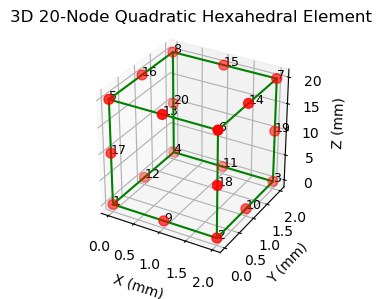

In [68]:
# Visualization of the 3D 20-node quadratic element
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111, projection='3d')

# Plot the nodes
ax.scatter(nodes_physical[:, 0], nodes_physical[:, 1], nodes_physical[:, 2], color='r', s=50)

# Define the edges of the hexahedral element for visualization
edges = [
    [0, 8, 1], [1, 9, 2], [2, 10, 3], [3,11, 0],   # Bottom face
    [4, 12, 5], [5, 13, 6], [6, 14, 7], [7, 15, 4],  # Top face
    [0, 16, 4], [1, 17, 5], [2, 18, 6], [3, 19, 7]  # Vertical edges
]

# Plot the edges
for edge in edges:
    for i in range(len(edge) - 1):
        x = [nodes_physical[edge[i], 0], nodes_physical[edge[i+1], 0]]
        y = [nodes_physical[edge[i], 1], nodes_physical[edge[i+1], 1]]
        z = [nodes_physical[edge[i], 2], nodes_physical[edge[i+1], 2]]
        ax.plot(x, y, z, 'g-')

# Label the nodes
for i, (x, y, z) in enumerate(nodes_physical):
    ax.text(x, y, z, f'{i+1}', size=9, zorder=1)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
# ax.set_xlabel(r'$\xi$')
# ax.set_ylabel(r'$\eta$')
# ax.set_zlabel(r'$\zeta$')
ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1
ax.set_title('3D 20-Node Quadratic Hexahedral Element')

plt.show()

# Assembly of Global Stiffness Matrix

## 1. Initialize Global Stiffness Matrix

In [11]:
import scipy.sparse as sps

# Number of elements in each direction
num_elements_x = 50
num_elements_y = 50
num_elements_z = 1

# Number of nodes in each direction
dof_per_node = 3
num_nodes_x = num_elements_x * 2 + 1  # 2 nodes per element in each direction
num_nodes_y = num_elements_y * 2 + 1
num_nodes_z = num_elements_z * 2 + 1

# Total number of nodes
num_nodes = num_nodes_x * num_nodes_y * num_nodes_z
size = num_nodes * dof_per_node

# Initialize the global stiffness matrix
K_global = sps.lil_matrix((size, size))

# Helper function to compute the global node index from (x, y, z) coordinates
def node_index(x, y, z):
    return z * num_nodes_x * num_nodes_y + y * num_nodes_x + x

# Define the connectivity for each element
connectivity = []
for k in range(num_elements_z):
    for j in range(num_elements_y):
        for i in range(num_elements_x):
            # Define the 20 nodes for the hexahedral element
            n0 = node_index(2*i, 2*j, 2*k)
            n1 = node_index(2*i+2, 2*j, 2*k)
            n2 = node_index(2*i+2, 2*j+2, 2*k)
            n3 = node_index(2*i, 2*j+2, 2*k)
            n4 = node_index(2*i, 2*j, 2*k+2)
            n5 = node_index(2*i+2, 2*j, 2*k+2)
            n6 = node_index(2*i+2, 2*j+2, 2*k+2)
            n7 = node_index(2*i, 2*j+2, 2*k+2)
            
            # Midpoints of edges
            n8 = node_index(2*i+1, 2*j, 2*k)
            n9 = node_index(2*i+2, 2*j+1, 2*k)
            n10 = node_index(2*i+1, 2*j+2, 2*k)
            n11 = node_index(2*i, 2*j+1, 2*k)
            n12 = node_index(2*i+1, 2*j, 2*k+2)
            n13 = node_index(2*i+2, 2*j+1, 2*k+2)
            n14 = node_index(2*i+1, 2*j+2, 2*k+2)
            n15 = node_index(2*i, 2*j+1, 2*k+2)
            n16 = node_index(2*i, 2*j, 2*k+1)
            n17 = node_index(2*i+2, 2*j, 2*k+1)
            n18 = node_index(2*i+2, 2*j+2, 2*k+1)
            n19 = node_index(2*i, 2*j+2, 2*k+1)
            
            connectivity.append([n0, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19])

## 2. Assembly of Global Stiffness Matrix

In [13]:
# Assemble the global stiffness matrix using the given assembly logic
for element in tqdm(connectivity):
    # Node coordinates for the current element
    nodes_physical = np.array([
        [element[0] % num_nodes_x, element[0] // num_nodes_x % num_nodes_y, element[0] // (num_nodes_x * num_nodes_y)],
        [element[1] % num_nodes_x, element[1] // num_nodes_x % num_nodes_y, element[1] // (num_nodes_x * num_nodes_y)],
        [element[2] % num_nodes_x, element[2] // num_nodes_x % num_nodes_y, element[2] // (num_nodes_x * num_nodes_y)],
        [element[3] % num_nodes_x, element[3] // num_nodes_x % num_nodes_y, element[3] // (num_nodes_x * num_nodes_y)],
        [element[4] % num_nodes_x, element[4] // num_nodes_x % num_nodes_y, element[4] // (num_nodes_x * num_nodes_y)],
        [element[5] % num_nodes_x, element[5] // num_nodes_x % num_nodes_y, element[5] // (num_nodes_x * num_nodes_y)],
        [element[6] % num_nodes_x, element[6] // num_nodes_x % num_nodes_y, element[6] // (num_nodes_x * num_nodes_y)],
        [element[7] % num_nodes_x, element[7] // num_nodes_x % num_nodes_y, element[7] // (num_nodes_x * num_nodes_y)],
        [element[8] % num_nodes_x, element[8] // num_nodes_x % num_nodes_y, element[8] // (num_nodes_x * num_nodes_y)],
        [element[9] % num_nodes_x, element[9] // num_nodes_x % num_nodes_y, element[9] // (num_nodes_x * num_nodes_y)],
        [element[10] % num_nodes_x, element[10] // num_nodes_x % num_nodes_y, element[10] // (num_nodes_x * num_nodes_y)],
        [element[11] % num_nodes_x, element[11] // num_nodes_x % num_nodes_y, element[11] // (num_nodes_x * num_nodes_y)],
        [element[12] % num_nodes_x, element[12] // num_nodes_x % num_nodes_y, element[12] // (num_nodes_x * num_nodes_y)],
        [element[13] % num_nodes_x, element[13] // num_nodes_x % num_nodes_y, element[13] // (num_nodes_x * num_nodes_y)],
        [element[14] % num_nodes_x, element[14] // num_nodes_x % num_nodes_y, element[14] // (num_nodes_x * num_nodes_y)],
        [element[15] % num_nodes_x, element[15] // num_nodes_x % num_nodes_y, element[15] // (num_nodes_x * num_nodes_y)],
        [element[16] % num_nodes_x, element[16] // num_nodes_x % num_nodes_y, element[16] // (num_nodes_x * num_nodes_y)],
        [element[17] % num_nodes_x, element[17] // num_nodes_x % num_nodes_y, element[17] // (num_nodes_x * num_nodes_y)],
        [element[18] % num_nodes_x, element[18] // num_nodes_x % num_nodes_y, element[18] // (num_nodes_x * num_nodes_y)],
        [element[19] % num_nodes_x, element[19] // num_nodes_x % num_nodes_y, element[19] // (num_nodes_x * num_nodes_y)]
    ], dtype=float)

    K_FE = compute_stiffness_matrix(nodes_physical)
    
    for i in range(20):  # Loop over local nodes
        for j in range(20):
            global_i = element[i]
            global_j = element[j]
            for k in range(3):  # Loop over DOFs per node
                for l in range(3):
                    GI = 3 * global_i + k
                    GJ = 3 * global_j + l
                    K_global[GI][GJ] += K_FE[3*i + k][3*j + l]
K_global

  0%|▎                                                                              | 8/2500 [01:29<7:47:09, 11.25s/it]

KeyboardInterrupt



In [8]:
import numpy as np
import scipy.sparse as sps
from tqdm import tqdm
from joblib import Parallel, delayed

# Number of elements in each direction
num_elements_x = 50
num_elements_y = 50
num_elements_z = 1

# Number of nodes in each direction
dof_per_node = 3
num_nodes_x = num_elements_x * 2 + 1  # 2 nodes per element in each direction
num_nodes_y = num_elements_y * 2 + 1
num_nodes_z = num_elements_z * 2 + 1

# Total number of nodes
num_nodes = num_nodes_x * num_nodes_y * num_nodes_z
size = num_nodes * dof_per_node

# Helper function to compute the global node index from (x, y, z) coordinates
def node_index(x, y, z):
    return z * num_nodes_x * num_nodes_y + y * num_nodes_x + x

# Define the connectivity for each element
connectivity = []
for k in range(num_elements_z):
    for j in range(num_elements_y):
        for i in range(num_elements_x):
            # Define the 20 nodes for the hexahedral element
            n0 = node_index(2*i, 2*j, 2*k)
            n1 = node_index(2*i+2, 2*j, 2*k)
            n2 = node_index(2*i+2, 2*j+2, 2*k)
            n3 = node_index(2*i, 2*j+2, 2*k)
            n4 = node_index(2*i, 2*j, 2*k+2)
            n5 = node_index(2*i+2, 2*j, 2*k+2)
            n6 = node_index(2*i+2, 2*j+2, 2*k+2)
            n7 = node_index(2*i, 2*j+2, 2*k+2)
            n8 = node_index(2*i+1, 2*j, 2*k)
            n9 = node_index(2*i+2, 2*j+1, 2*k)
            n10 = node_index(2*i+1, 2*j+2, 2*k)
            n11 = node_index(2*i, 2*j+1, 2*k)
            n12 = node_index(2*i+1, 2*j, 2*k+2)
            n13 = node_index(2*i+2, 2*j+1, 2*k+2)
            n14 = node_index(2*i+1, 2*j+2, 2*k+2)
            n15 = node_index(2*i, 2*j+1, 2*k+2)
            n16 = node_index(2*i, 2*j, 2*k+1)
            n17 = node_index(2*i+2, 2*j, 2*k+1)
            n18 = node_index(2*i+2, 2*j+2, 2*k+1)
            n19 = node_index(2*i, 2*j+2, 2*k+1)
            connectivity.append([n0, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19])
            
def assemble_element(element):
    # Node coordinates for the current element
    nodes_physical = np.array([
        [element[0] % num_nodes_x, element[0] // num_nodes_x % num_nodes_y, element[0] // (num_nodes_x * num_nodes_y)],
        [element[1] % num_nodes_x, element[1] // num_nodes_x % num_nodes_y, element[1] // (num_nodes_x * num_nodes_y)],
        [element[2] % num_nodes_x, element[2] // num_nodes_x % num_nodes_y, element[2] // (num_nodes_x * num_nodes_y)],
        [element[3] % num_nodes_x, element[3] // num_nodes_x % num_nodes_y, element[3] // (num_nodes_x * num_nodes_y)],
        [element[4] % num_nodes_x, element[4] // num_nodes_x % num_nodes_y, element[4] // (num_nodes_x * num_nodes_y)],
        [element[5] % num_nodes_x, element[5] // num_nodes_x % num_nodes_y, element[5] // (num_nodes_x * num_nodes_y)],
        [element[6] % num_nodes_x, element[6] // num_nodes_x % num_nodes_y, element[6] // (num_nodes_x * num_nodes_y)],
        [element[7] % num_nodes_x, element[7] // num_nodes_x % num_nodes_y, element[7] // (num_nodes_x * num_nodes_y)],
        [element[8] % num_nodes_x, element[8] // num_nodes_x % num_nodes_y, element[8] // (num_nodes_x * num_nodes_y)],
        [element[9] % num_nodes_x, element[9] // num_nodes_x % num_nodes_y, element[9] // (num_nodes_x * num_nodes_y)],
        [element[10] % num_nodes_x, element[10] // num_nodes_x % num_nodes_y, element[10] // (num_nodes_x * num_nodes_y)],
        [element[11] % num_nodes_x, element[11] // num_nodes_x % num_nodes_y, element[11] // (num_nodes_x * num_nodes_y)],
        [element[12] % num_nodes_x, element[12] // num_nodes_x % num_nodes_y, element[12] // (num_nodes_x * num_nodes_y)],
        [element[13] % num_nodes_x, element[13] // num_nodes_x % num_nodes_y, element[13] // (num_nodes_x * num_nodes_y)],
        [element[14] % num_nodes_x, element[14] // num_nodes_x % num_nodes_y, element[14] // (num_nodes_x * num_nodes_y)],
        [element[15] % num_nodes_x, element[15] // num_nodes_x % num_nodes_y, element[15] // (num_nodes_x * num_nodes_y)],
        [element[16] % num_nodes_x, element[16] // num_nodes_x % num_nodes_y, element[16] // (num_nodes_x * num_nodes_y)],
        [element[17] % num_nodes_x, element[17] // num_nodes_x % num_nodes_y, element[17] // (num_nodes_x * num_nodes_y)],
        [element[18] % num_nodes_x, element[18] // num_nodes_x % num_nodes_y, element[18] // (num_nodes_x * num_nodes_y)],
        [element[19] % num_nodes_x, element[19] // num_nodes_x % num_nodes_y, element[19] // (num_nodes_x * num_nodes_y)]
    ], dtype=float)

    K_FE = compute_stiffness_matrix(nodes_physical)
    
    rows = []
    cols = []
    data = []
    
    for i in range(20):  # Loop over local nodes
        for j in range(20):
            global_i = element[i]
            global_j = element[j]
            for k in range(3):  # Loop over DOFs per node
                for l in range(3):
                    GI = 3 * global_i + k
                    GJ = 3 * global_j + l
                    rows.append(GI)
                    cols.append(GJ)
                    data.append(K_FE[3*i + k, 3*j + l])
                    
    return rows, cols, data

# Use parallel processing to assemble the global stiffness matrix
results = Parallel(n_jobs=-1)(delayed(assemble_element)(element) for element in tqdm(connectivity))

# Combine the results
rows = np.concatenate([result[0] for result in results])
cols = np.concatenate([result[1] for result in results])
data = np.concatenate([result[2] for result in results])

# Create the sparse global stiffness matrix
K_global = sps.csr_matrix((data, (rows, cols)), shape=(size, size))

 38%|████████████████████████████▉                                                | 940/2500 [52:44<8:42:12, 20.09s/it]

KeyboardInterrupt: 